# Exploration

The solver below is very similar to the one in the scheduler package. 

The problem can be approach via various solvers but the CP-SAT solver is the most efficient one and also easy to use.

Note that the solver package is unit tested while this one is an initial take.



Solution:


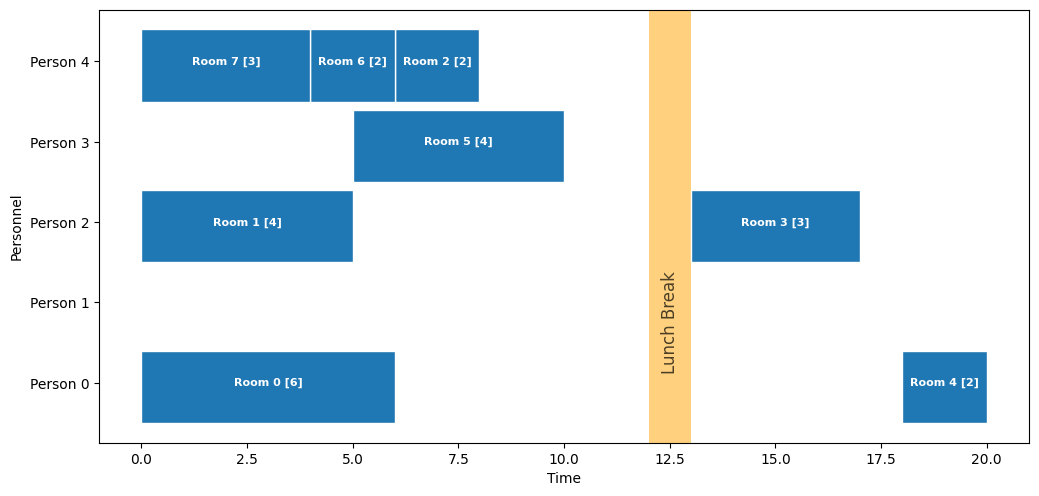

Person 0:
 [0, 6]: 0
 [18, 20]: 4
Person 1:
Person 2:
 [0, 5]: 1
 [13, 17]: 3
Person 3:
 [5, 10]: 5
Person 4:
 [0, 4]: 7
 [4, 6]: 6
 [6, 8]: 2


In [1]:
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt
import matplotlib as mpl


class MaintenanceScheduleSolver:
    def __init__(self, rooms, personnel, availability, skills, times, delays, lunch_break, lunch_duration):
        self.rooms = rooms
        self.personnel = personnel
        self.availability = availability
        self.skills = skills
        self.times = times  # Time required to maintain each room
        self.delays = delays  # Delay between rooms for each personnel
        self.lunch_break = lunch_break  # Fixed lunch break start time
        self.lunch_duration = lunch_duration  # Fixed lunch break duration

        self.num_rooms = len(rooms)
        self.num_personnel = len(personnel)

        self.model = cp_model.CpModel()
        self.assignments = {}
        self.start_times = {}
        self.end_times = {}
        self.before_lunch_constraints = {}
        self.after_lunch_constraints = {}

        self.create_variables()
        self.add_constraints()

    def create_variables(self):
        """
            Creates decision variables for the assignment of personnel to rooms and start times.
        """

        # Flatten the 2D list self.delays
        flattened_delays = [delay for sublist in self.delays for delay in sublist]

        # Calculate the upper bound for the start and end times
        upper_bound = sum(self.times) + sum(flattened_delays)

        for r in range(self.num_rooms):
            for p in range(self.num_personnel):
                # Assignment variable: 1 if person p is assigned to room r, else 0
                self.assignments[(r, p)] = self.model.NewBoolVar(f'assign_r{r}_p{p}')

                # Start time variable for each room and personnel
                self.start_times[(r, p)] = self.model.NewIntVar(0, upper_bound, f'start_r{r}_p{p}')

                # End time is derived from start time and the room's maintenance duration
                self.end_times[(r, p)] = self.model.NewIntVar(0, upper_bound, f'end_r{r}_p{p}')

                self.before_lunch_constraints[(r, p)] = self.model.NewBoolVar(f'before_lunch_r{r}_p{p}')
                self.after_lunch_constraints[(r, p)] = self.model.NewBoolVar(f'after_lunch_r{r}_p{p}')

    def add_constraints(self):
        """Adds constraints to the model."""
        # Ensure each room is assigned exactly to one available and skilled person
        for r in range(self.num_rooms):
            room_type = self.rooms[r]
            self.model.AddExactlyOne(self.assignments[(r, p)] for p in range(self.num_personnel) if self.skills[p][room_type])

        # Ensure that the maintenance person respects the skill requirement and availability
        for p in range(self.num_personnel):
            # total_rooms_assigned = sum(self.assignments[(r, p)] for r in range(self.num_rooms))
            # self.model.Add(total_rooms_assigned <= self.availability[p])

            total_time = sum(self.times[r] * self.assignments[r, p] for r in range(self.num_rooms))
            self.model.Add(total_time <= self.availability[p])

            person_intervals = []

            # Add time constraints: the start time, end time, and delays between consecutive tasks
            for r in range(self.num_rooms):
                if self.skills[p][self.rooms[r]]:
                    room_duration = self.times[r]
                    room_delay = self.delays[p][r]

                    # End time = Start time + Duration of the room + Delay between rooms
                    self.model.Add(self.end_times[(r, p)] == self.start_times[(r, p)] + room_duration + room_delay).OnlyEnforceIf(self.assignments[(r, p)])

                    interval = self.model.NewIntervalVar(self.start_times[(r, p)], room_duration + room_delay, self.end_times[(r, p)], f"interval_r{r}_p{p}")
                    person_intervals.append(interval)

            # ensure intervals do not overlap
            self.model.AddNoOverlap(person_intervals)

            # Add lunch break constraint: no maintenance during lunch
            for r in range(self.num_rooms):
                room_duration = self.times[r]

                # Lunch break (start times must not conflict with lunch time)
                self.model.Add(self.start_times[(r, p)] + room_duration <= self.lunch_break).OnlyEnforceIf(self.before_lunch_constraints[(r, p)])
                self.model.Add(self.start_times[(r, p)] + room_duration > self.lunch_break).OnlyEnforceIf(self.before_lunch_constraints[(r, p)].Not())

                self.model.Add(self.start_times[(r, p)] >= self.lunch_break + self.lunch_duration).OnlyEnforceIf(self.after_lunch_constraints[(r, p)])
                self.model.Add(self.start_times[(r, p)] < self.lunch_break + self.lunch_duration).OnlyEnforceIf(self.after_lunch_constraints[(r, p)].Not())

                self.model.AddBoolOr(
                    [
                        self.before_lunch_constraints[(r, p)],
                        self.after_lunch_constraints[(r, p)]
                    ]
                )

    def visualize_gantt_chart(self, solver):
        fig, ax = plt.subplots(1, 1, figsize=(12, 5 + self.num_personnel / 8))
        ax.set_xlabel('Time')
        ax.set_ylabel('Personnel')
        bar_style = {'alpha': 1.0, 'lw': 25, 'solid_capstyle': 'butt'}
        text_style = {'color': 'white', 'weight': 'bold', 'ha': 'center', 'va': 'center', 'fontsize': 8}
        colors = mpl.cm.Dark2.colors

        ax.set_yticks([10 * i for i in range(self.num_personnel)])
        ax.set_yticklabels([f'Person {i}' for i in range(self.num_personnel)])

        # Draw a band for the lunch break
        ax.axvspan(self.lunch_break, self.lunch_break + self.lunch_duration, facecolor='orange', alpha=0.5)
        ax.text(self.lunch_break + self.lunch_duration / 2, self.num_personnel / 2 + 5, 'Lunch Break', rotation=90, va='center', ha='center', color='black', fontsize=12, alpha=0.7)

        for p in range(self.num_personnel):
            for r in range(self.num_rooms):
                if solver.BooleanValue(self.assignments[(r, p)]):
                    start_time = solver.Value(self.start_times[(r, p)])
                    end_time = solver.Value(self.end_times[(r, p)])
                    ax.broken_barh([(start_time, end_time - start_time)], (10 * p - 5, 9), facecolors=('tab:blue'), edgecolor='white')
                    ax.text(start_time + (end_time - start_time) / 2, 10 * p, f'Room {r} [{self.times[r]}]', **text_style)

        # fig.tight_layout()
        plt.show()

    def schedule_for_person(self, p):
        """
            Returns the schedule for a given person.
            The schedule is a list of tuples (start_time, end_time, room, duration).
        """
        schedule = []
        for r in range(self.num_rooms):
            if solver.BooleanValue(self.assignments[(r, p)]):
                start_time = solver.Value(self.start_times[(r, p)])
                end_time = solver.Value(self.end_times[(r, p)])
                schedule.append((start_time, end_time, r, end_time - start_time))
        schedule.sort(key=lambda x: x[0])
        return schedule

    def solve(self):
        """Solves the scheduling problem and prints the result."""
        solver = cp_model.CpSolver()
        status = solver.Solve(self.model)

        if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
            print('Solution:')
            self.visualize_gantt_chart(solver)
            for p in range(self.num_personnel):
                print(f'Person {p}:')
                schedule = []
                for r in range(self.num_rooms):
                    if solver.BooleanValue(self.assignments[(r, p)]):
                        start_time = solver.Value(self.start_times[(r, p)])
                        end_time = solver.Value(self.end_times[(r, p)])
                        schedule.append((start_time, end_time, r))
                schedule.sort(key=lambda x: x[0])
                for start_time, end_time, r in schedule:
                    print(f' [{start_time}, {end_time}]: {r}')
        else:
            print('No solution found.')


# Example data
rooms = ['type_A', 'type_B', 'type_C', 'type_B', 'type_A', 'type_B', 'type_C', 'type_C']  # Room types (4 rooms)
personnel = ['P0', 'P1', 'P2', 'P3', 'P4']  # Personnel (5 people)

# Availability: Maximum number of rooms each person can handle
availability = [10, 3, 15, 10, 8]

# Skills: Which rooms each person can maintain
skills = [
    {'type_A': True, 'type_B': False, 'type_C': True},  # P1
    {'type_A': True, 'type_B': True, 'type_C': False},  # P2
    {'type_A': False, 'type_B': True, 'type_C': True},  # P3
    {'type_A': False, 'type_B': True, 'type_C': True},  # P4
    {'type_A': False, 'type_B': False, 'type_C': True},  # P5
]

# Time required for each room (in arbitrary time units)
times = [6, 4, 2, 3, 2, 4, 2, 3]

# Delays between rooms for each personnel (in arbitrary time units)
delays = [
    [0, 1, 2, 1, 0, 1, 2, 1],  # Delays for P0 between rooms
    [1, 0, 1, 2, 0, 1, 0, 1],  # Delays for P1 between rooms
    [0, 1, 0, 1, 0, 1, 0, 1],  # Delays for P2 between rooms
    [0, 1, 0, 1, 0, 1, 0, 1],  # Delays for P3 between rooms
    [0, 1, 0, 1, 0, 1, 0, 1],  # Delays for P4 between rooms
]

# Lunch break time (start of lunch) and duration (in arbitrary time units)
lunch_break = 12  # Lunch break starts at time 5
lunch_duration = 1  # Lunch duration is 1 unit of time

# Create the solver instance and solve the problem
solver = MaintenanceScheduleSolver(rooms, personnel, availability, skills, times, delays, lunch_break, lunch_duration)
solver.solve()